In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.6 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_dataset"
DATASET = "ashkhagan/figshare-brain-tumor-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset


In [3]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))

paths, labels = [], []

for f in mat_files:
    with h5py.File(f, "r") as mat:
        if "label" in mat:
            label = int(mat["label"][()][0][0])
        else:
            label = int(mat["cjdata"]["label"][()][0][0])
    paths.append(f)
    labels.append(label - 1)

df = pd.DataFrame({"image_path": paths, "label": labels})
num_classes = df["label"].nunique()

train_df, test_df = train_test_split(df, stratify=df.label, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(train_df, stratify=train_df.label, test_size=0.2, random_state=42)


In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        with h5py.File(path, "r") as mat:
            if "image" in mat:
                img = mat["image"][()]
            else:
                img = mat["cjdata"]["image"][()]

        img = np.array(img).T
        img = np.stack([img]*3, axis=-1).astype(np.uint8)
        img = self.transform(img)

        return img, label


In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

train_loader = DataLoader(BrainTumorDataset(train_df, transform), batch_size=8, shuffle=True)
val_loader   = DataLoader(BrainTumorDataset(val_df, transform), batch_size=8)
test_loader  = DataLoader(BrainTumorDataset(test_df, transform), batch_size=8)


In [6]:
model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)

summary(model, input_size=(1,3,224,224))


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 3]                    152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Identity: 2-2                     [1, 196, 768]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Identity: 1-3                          [1, 197, 768]             --
├─Identity: 1-4                          [1, 197, 768]             --
├─Sequential: 1-5                        [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─Attention: 3-2               [1, 197, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─Identity: 3-4                [1, 197, 768]           

In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [8]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [9]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]")

    for x,y in pbar:
        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out,y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k:v.compute().item() for k,v in train_metrics.items()}

    print(f"Metrics - loss: {train_loss:.4f}, accuracy: {train_out['acc']:.4f}, "
          f"precision: {train_out['precision']:.4f}, recall: {train_out['recall']:.4f}, "
          f"f1_score: {train_out['f1']:.4f}, specificity: {train_spec:.4f}, "
          f"sensitivity: {train_sens:.4f}, mcc: {train_out['mcc']:.4f}, "
          f"auc: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x,y in tqdm(val_loader, desc="Validating Model"):
            x,y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out,y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out,y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k:v.compute().item() for k,v in val_metrics.items()}

    print(f"Metrics - loss: {val_loss:.4f}, accuracy: {val_out['acc']:.4f}, "
          f"precision: {val_out['precision']:.4f}, recall: {val_out['recall']:.4f}, "
          f"f1_score: {val_out['f1']:.4f}, specificity: {val_spec:.4f}, "
          f"sensitivity: {val_sens:.4f}, mcc: {val_out['mcc']:.4f}, "
          f"auc: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training Model - Epoch [1/30]: 100%|██████████| 245/245 [01:38<00:00,  2.48it/s]


Metrics - loss: 1.0759, accuracy: 0.4942, precision: 0.5062, recall: 0.4942, f1_score: 0.4932, specificity: 0.7561, sensitivity: 0.4942, mcc: 0.2751, auc: 0.6828


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  5.97it/s]


Metrics - loss: 0.7595, accuracy: 0.5455, precision: 0.6113, recall: 0.5455, f1_score: 0.5151, specificity: 0.7873, sensitivity: 0.5455, mcc: 0.4369, auc: 0.8623
Current LR: 5.000000e-04



Training Model - Epoch [2/30]: 100%|██████████| 245/245 [01:32<00:00,  2.65it/s]


Metrics - loss: 0.8271, accuracy: 0.5801, precision: 0.5918, recall: 0.5801, f1_score: 0.5798, specificity: 0.8002, sensitivity: 0.5801, mcc: 0.4090, auc: 0.7834


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  5.78it/s]


Metrics - loss: 0.7716, accuracy: 0.5665, precision: 0.4268, recall: 0.5665, f1_score: 0.4840, specificity: 0.8024, sensitivity: 0.5665, mcc: 0.4425, auc: 0.8388
Current LR: 4.986305e-04



Training Model - Epoch [3/30]: 100%|██████████| 245/245 [01:32<00:00,  2.64it/s]


Metrics - loss: 0.6809, accuracy: 0.6480, precision: 0.6677, recall: 0.6480, f1_score: 0.6452, specificity: 0.8383, sensitivity: 0.6480, mcc: 0.5279, auc: 0.8554


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  6.05it/s]


Metrics - loss: 0.5759, accuracy: 0.7264, precision: 0.7472, recall: 0.7264, f1_score: 0.7125, specificity: 0.8823, sensitivity: 0.7264, mcc: 0.6477, auc: 0.9202
Current LR: 4.945369e-04



Training Model - Epoch [4/30]: 100%|██████████| 245/245 [01:32<00:00,  2.66it/s]


Metrics - loss: 0.5827, accuracy: 0.7160, precision: 0.7205, recall: 0.7160, f1_score: 0.7162, specificity: 0.8678, sensitivity: 0.7160, mcc: 0.6032, auc: 0.8931


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  5.99it/s]


Metrics - loss: 0.8531, accuracy: 0.6897, precision: 0.7167, recall: 0.6897, f1_score: 0.6687, specificity: 0.8537, sensitivity: 0.6897, mcc: 0.5717, auc: 0.8899
Current LR: 4.877641e-04



Training Model - Epoch [5/30]: 100%|██████████| 245/245 [01:32<00:00,  2.66it/s]


Metrics - loss: 0.5213, accuracy: 0.7534, precision: 0.7549, recall: 0.7534, f1_score: 0.7529, specificity: 0.8889, sensitivity: 0.7534, mcc: 0.6601, auc: 0.9128


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  5.78it/s]


Metrics - loss: 0.6415, accuracy: 0.7415, precision: 0.7720, recall: 0.7415, f1_score: 0.7094, specificity: 0.8681, sensitivity: 0.7415, mcc: 0.6098, auc: 0.9279
Current LR: 4.783864e-04



Training Model - Epoch [6/30]: 100%|██████████| 245/245 [01:31<00:00,  2.67it/s]


Metrics - loss: 0.3863, accuracy: 0.8273, precision: 0.8231, recall: 0.8273, f1_score: 0.8250, specificity: 0.9213, sensitivity: 0.8273, mcc: 0.7555, auc: 0.9498


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  5.98it/s]


Metrics - loss: 0.6448, accuracy: 0.6930, precision: 0.7596, recall: 0.6930, f1_score: 0.6787, specificity: 0.8626, sensitivity: 0.6930, mcc: 0.6104, auc: 0.9215
Current LR: 4.665064e-04



Training Model - Epoch [7/30]: 100%|██████████| 245/245 [01:31<00:00,  2.67it/s]


Metrics - loss: 0.4572, accuracy: 0.7907, precision: 0.7898, recall: 0.7907, f1_score: 0.7900, specificity: 0.9011, sensitivity: 0.7907, mcc: 0.7002, auc: 0.9339


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  5.80it/s]


Metrics - loss: 0.6211, accuracy: 0.6847, precision: 0.7186, recall: 0.6847, f1_score: 0.6938, specificity: 0.8544, sensitivity: 0.6847, mcc: 0.5782, auc: 0.9010
Current LR: 4.522542e-04



Training Model - Epoch [8/30]: 100%|██████████| 245/245 [01:32<00:00,  2.66it/s]


Metrics - loss: 0.3878, accuracy: 0.8324, precision: 0.8329, recall: 0.8324, f1_score: 0.8320, specificity: 0.9248, sensitivity: 0.8324, mcc: 0.7676, auc: 0.9530


Validating Model: 100%|██████████| 62/62 [00:10<00:00,  5.86it/s]

Metrics - loss: 0.6587, accuracy: 0.7394, precision: 0.7415, recall: 0.7394, f1_score: 0.7391, specificity: 0.8813, sensitivity: 0.7394, mcc: 0.6314, auc: 0.9064
Current LR: 4.357862e-04

Early stopping triggered.


In [10]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [11]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 77/77 [00:13<00:00,  5.86it/s]


===== TEST RESULTS =====
Test Loss: 0.5931
ACC: 0.7139
PRECISION: 0.7193
RECALL: 0.7139
F1: 0.6950
AUC: 0.9133
MCC: 0.6252


In [12]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.5977    0.3662    0.4541       142
           1     0.8911    0.7754    0.8293       285
           2     0.6691    1.0000    0.8017       186

    accuracy                         0.7488       613
   macro avg     0.7193    0.7139    0.6950       613
weighted avg     0.7558    0.7488    0.7340       613



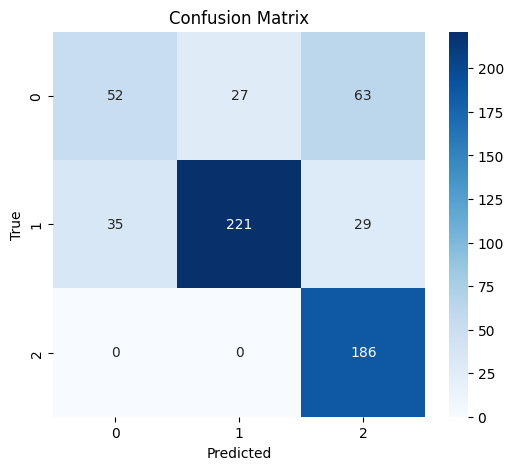

In [13]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [14]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


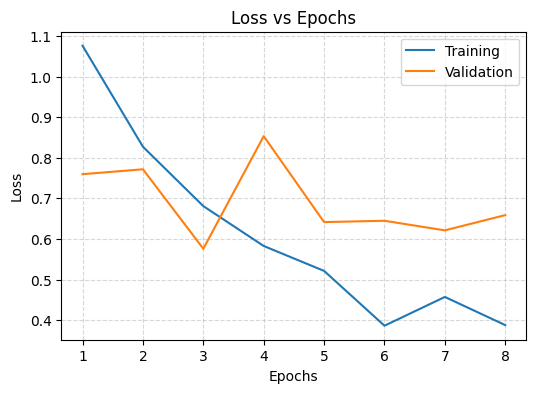

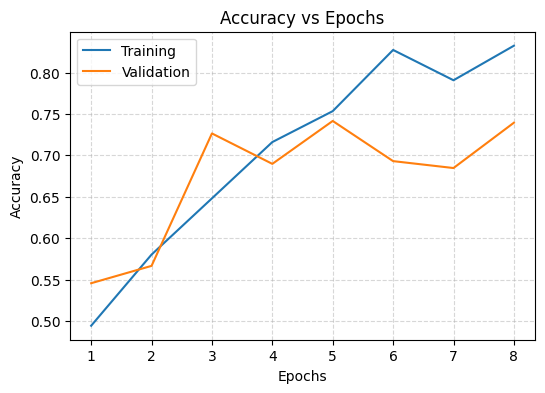

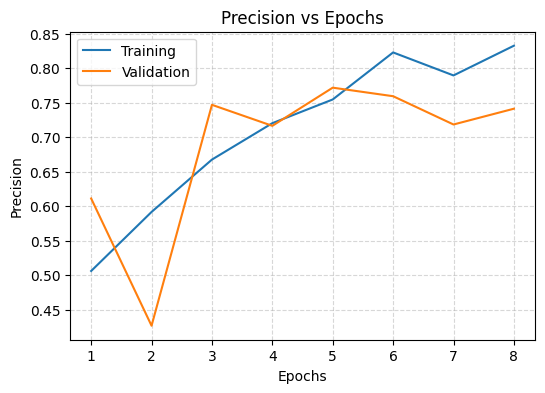

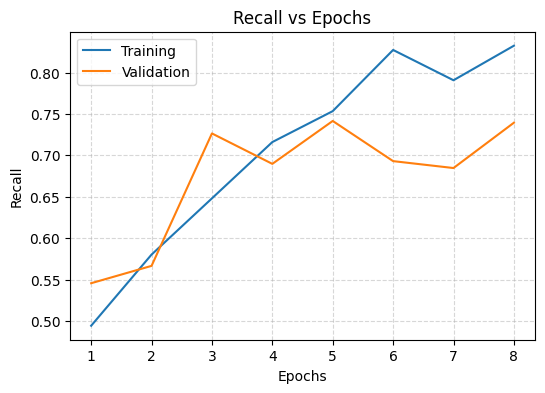

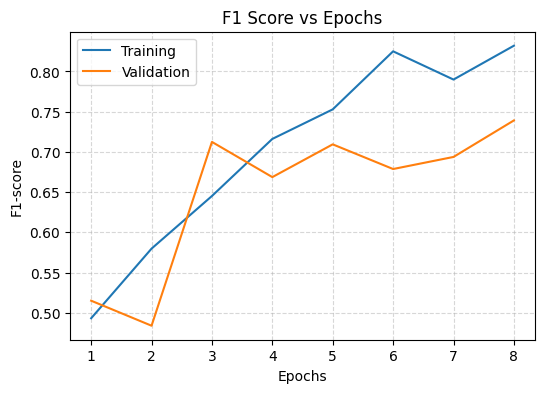

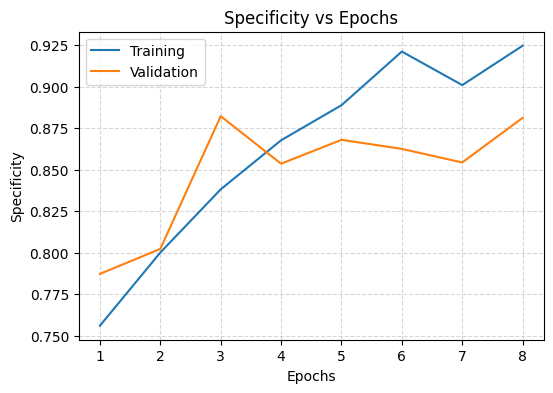

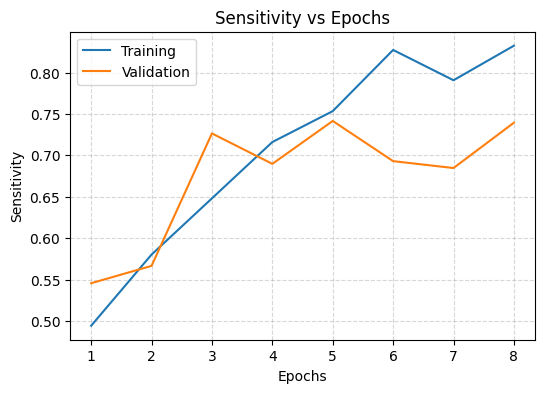

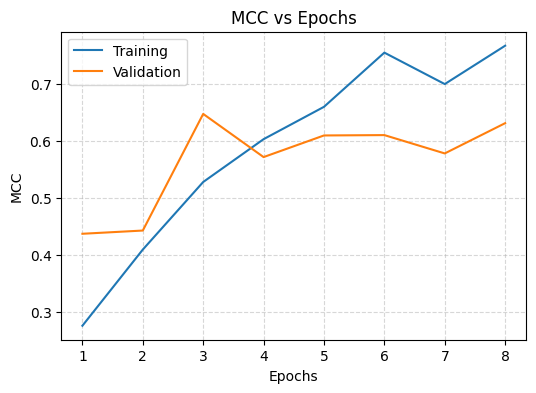

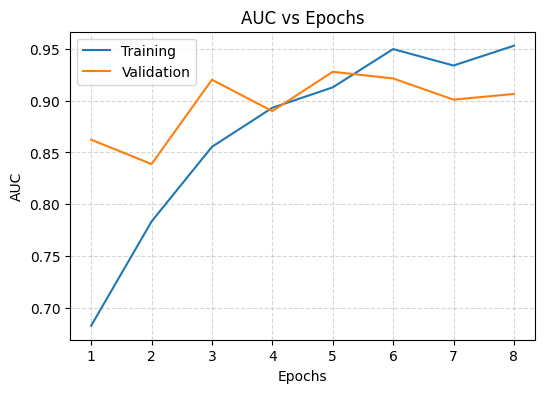

In [15]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
